# EDA for Delivery Time Prediction  
Exploratory Data Analysis for "E2E OWP MLOps: Delivery Time Prediction" Project

## Imports and Global Constants

In [738]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from IPython.display import display

In [739]:
# Set display options
pd.set_option('display.max_columns', None)

# Define root data path depending on environment (Docker vs Local)
DOCKER_DATA_PATH = "/srv/data/dataset"
LOCAL_DATA_PATH = "../../data_store/dataset"

DATA_PATH = DOCKER_DATA_PATH if os.path.exists(DOCKER_DATA_PATH) else LOCAL_DATA_PATH

COLOR_TEXT = plt.get_cmap('PuBu')(0.85)  # color for subtitles
FIG_WIDTH = 10
FIG_HEIGHT = 6

RANDOM_SEED = 42

## Functions

In [740]:
def describe_dataset(df, show=True, stat=True, include_head=False):
    """
    Display basic metadata and statistics about a DataFrame.
    """
    summary = {
        'column name': df.columns,
        'type': df.dtypes.values,
        '# non-null': df.count().values,
        '# missing (NaN)': df.isnull().sum().values,
        '# unique': df.nunique().values
    }

    if include_head:
        for i in range(min(3, len(df))):
            summary[f'row {i+1}'] = df.iloc[i].values

    if stat:
        describe_df = df.describe(include='all')
        for stat_name in ['min', 'mean', '50%', 'max']:
            if stat_name in describe_df.index:
                summary[stat_name] = describe_df.loc[stat_name].values

    summary_df = pd.DataFrame(summary)
    
    if show:
        display(summary_df)
    else:
        return summary_df

def hist_boxplot(column_names, df_input, labels, bins, suptitle):
    """
    Display a histogram and boxplot for one or more numerical columns.

    Parameters:
    column_names (list of str): List of column names to visualize.
    df_input (DataFrame): The DataFrame containing the columns.
    labels (list of str): Labels to show in the histogram legend.
    bins (int): Number of bins to use in the histogram.
    suptitle (str): Title for the entire plot.
    """

    plt.rcParams['figure.figsize'] = (FIG_WIDTH, FIG_HEIGHT)
    plt.rc('axes', labelsize=14)

    fig = plt.figure()
    gs = GridSpec(ncols=1, nrows=4, figure=fig)

    # Histogram (top)
    ax1 = plt.subplot(gs[0:3, 0])
    for col, label in zip(column_names, labels):
        sns.histplot(df_input[col], ax=ax1, bins=bins, label=label, alpha=0.5)

    ax1.set_xlabel("")
    ax1.set_ylabel('Frequency (count)')
    ax1.tick_params(axis='x', which='major', labelbottom=False)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), fontsize=12)

    # Boxplot (bottom)
    ax2 = plt.subplot(gs[3, 0])
    sns.boxplot(data=df_input[column_names], ax=ax2, orient='h')
    ax2.tick_params(axis='x', which='major', labelsize=12)
    ax2.tick_params(axis='y', which='major', labelsize=12)

    # Main title
    plt.suptitle(f'Histogram and Boxplot for "{suptitle}"', fontsize=16, color=COLOR_TEXT)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

def hist_boxplot_hue(d_name_column,d_df, d_xlable, d_bins, d_hue):
    '''
    Display a histogram and boxplot for one or more numerical columns.
    '''

    plt.rcParams['figure.figsize'] = (FIG_WIDTH, FIG_HEIGHT)
    plt.rc('axes', labelsize=14)

    temp_df=d_df[[d_name_column,d_hue]]
    print(type(temp_df))

    fig = plt.figure()
    gs = GridSpec(ncols=1, nrows=4, figure=fig)

    ax1 = plt.subplot(gs[0:3, 0])
    ax2 = plt.subplot(gs[3, 0])

    sns.histplot(data=temp_df, x=d_name_column, hue=d_hue, ax=ax1, bins=d_bins)

    ax1.set_xlabel("")
    ax1.set(ylabel='Frequency (count)')
    ax1.tick_params(axis='x', which='major', labelbottom=False)
    ax1.tick_params(axis='y', which='major', labelsize=12)
    plt.suptitle(f'Histogram and Boxplot for \'{d_name_column}\' ({d_xlable})', fontsize=14, color=COLOR_TEXT)

    sns.boxplot(data=temp_df, x=d_name_column, y=d_hue, ax=ax2, orient='h')
    ax2.set(xlabel=d_xlable)
    ax2.tick_params(axis='x', which='major', labelsize=12)

    plt.show()
    return

def borders_of_outliers(column_name, df_input, show=True):
    """
    Display the outlier boundaries (IQR method) for a numerical column.

    Parameters:
    column_name (str): The name of the column to analyze.
    df_input (DataFrame): The DataFrame containing the column.
    """
    temp_series = df_input[column_name].copy()
    IQR = temp_series.quantile(0.75) - temp_series.quantile(0.25)
    q25 = temp_series.quantile(0.25)
    q75 = temp_series.quantile(0.75)
    left_border = q25 - 1.5 * IQR
    right_border = q75 + 1.5 * IQR

    result_dict = {
        'Outlier Boundaries': [left_border, right_border],
        'Outlier Count': [
            (temp_series < left_border).sum(),
            (temp_series > right_border).sum()
        ]
    }

    outlier_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Left', 'Right'])

    if show:
        display(outlier_df)
    else:
        return outlier_df
    


## Load and Preview

In [741]:
# List files in dataset directory
print(f"Using data path: {DATA_PATH}")
print("Files in data directory:\n\t", end="")
print(*os.listdir(DATA_PATH), sep='\n\t')


Using data path: ../../data_store/dataset
Files in data directory:
	olist_orders_dataset.csv
	olist_order_items_dataset.csv
	olist_products_dataset.csv
	product_category_name_translation.csv
	olist_sellers_dataset.csv
	olist_customers_dataset.csv
	olist_order_payments_dataset.csv
	olist_order_reviews_dataset.csv
	olist_geolocation_dataset.csv


In [742]:
FILES = {f[6:-12]: f for f in os.listdir(DATA_PATH) if f.endswith('.csv')}
FILES['product_category_name_translation'] = FILES.pop('t_category_name_tra')

In [743]:
df = {}
for i, f in enumerate(FILES):
    FILE = FILES[f]
    df[f] = pd.read_csv(DATA_PATH + "/" + FILE)

###  orders_dataset

In [744]:
ds = 'orders'

In [745]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
Info dataset: None


In [746]:
# Preview first few rows
display(df[ds].head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [747]:
# Print column-wise summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,order_id,object,99441,0,99441,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d
1,customer_id,object,99441,0,99441,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089
2,order_status,object,99441,0,8,delivered,delivered,delivered
3,order_purchase_timestamp,object,99441,0,98875,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49
4,order_approved_at,object,99281,160,90733,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23
5,order_delivered_carrier_date,object,97658,1783,81018,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00
6,order_delivered_customer_date,object,96476,2965,95664,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29
7,order_estimated_delivery_date,object,99441,0,459,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00


In [748]:
df[ds].order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [749]:
dt_cols = describe_dataset(df[ds].select_dtypes(include = ['object']), show=False, stat=False)['column name'][3:]

In [750]:
# Сonvert columns to datetime format
for col in dt_cols:
    df[ds][col] = pd.to_datetime(df[ds][col])

In [751]:
df[ds][dt_cols].describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


#### Dataset Overview: Orders

The dataset `olist_orders_dataset.csv` contains information about 99,441 customer orders. It includes 8 columns, all in `snake_case` format and compliant with PEP8.

##### Column Descriptions:

| Column name                    | Description                                 |
|--------------------------------|---------------------------------------------|
| `order_id`                     | Unique order identifier                     |
| `customer_id`                  | Unique customer identifier                  |
| `order_status`                 | Current order status                        |
| `order_purchase_timestamp`     | Timestamp of order placement                |
| `order_approved_at`            | Timestamp of payment approval               |
| `order_delivered_carrier_date` | Timestamp when the order was shipped        |
| `order_delivered_customer_date`| Timestamp when the order was delivered      |
| `order_estimated_delivery_date`| Estimated delivery date provided to customer|

##### General Observations:

- All columns are stored as strings (`object` dtype), but 5 of them represent timestamps and should be converted to `datetime` format for analysis.
- No duplicates detected in `order_id` or `customer_id`.
- Missing values are present in some date-related columns:
  - `order_approved_at`: 160 missing
  - `order_delivered_carrier_date`: 1,783 missing
  - `order_delivered_customer_date`: 2,965 missing
- The `order_status` column contains 8 unique values such as `'delivered'`, `'shipped'`, `'canceled'`, `'unavailable'`, etc.
- The time range spans from **September 2016** to **October 2018**, providing more than two years of data.

##### Analysis Focus:

The main goal of this project is to **predict delivery time**. Therefore, the analysis will focus only on orders with status `'delivered'`. The **delivery time** will be calculated as the time difference between `order_purchase_timestamp` and `order_delivered_customer_date`.

##### Hypotheses for Exploration:

- What is the typical delivery time for completed orders?
- How accurate is the estimated delivery date compared to the actual delivery?
- Are there patterns in delivery delays depending on seasonality, customer location, or seller?
- How long does it typically take from order approval to shipment, and does it affect overall delivery time?

Further preprocessing and data joining with other datasets (e.g., items, customers, sellers) will allow deeper exploration of these questions.


###  order_items_dataset

In [752]:
ds = 'order_items'

In [753]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
Info dataset: None


In [754]:
# Preview first few rows
display(df[ds].head())

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [755]:
# Print column-number summary
describe_dataset(df[ds].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,order_item_id,int64,112650,0,21,1.00,1.197834,1.00,21.00
1,price,float64,112650,0,5968,0.85,120.653739,74.99,6735.00
2,freight_value,float64,112650,0,6999,0.00,19.990320,16.26,409.68


In [756]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,order_id,object,112650,0,98666,00010242fe8c5a6d1ba2dd792cb16214,00018f77f2f0320c557190d7a144bdd3,000229ec398224ef6ca0657da4fc703e
1,product_id,object,112650,0,32951,4244733e06e7ecb4970a6e2683c13e61,e5f2d52b802189ee658865ca93d83a8f,c777355d18b72b67abbeef9df44fd0fd
2,seller_id,object,112650,0,3095,48436dade18ac8b2bce089ec2a041202,dd7ddc04e1b6c2c614352b383efe2d36,5b51032eddd242adc84c38acab88f23d
3,shipping_limit_date,object,112650,0,93318,2017-09-19 09:45:35,2017-05-03 11:05:13,2018-01-18 14:48:30


In [757]:
# Сonvert columns to datetime format
df[ds]['shipping_limit_date'] = pd.to_datetime(df[ds]['shipping_limit_date'])

In [758]:
df[ds]['shipping_limit_date'].describe()

count                           112650
mean     2018-01-07 15:36:52.192685312
min                2016-09-19 00:15:34
25%         2017-09-20 20:57:27.500000
50%                2018-01-26 13:59:35
75%      2018-05-10 14:34:00.750000128
max                2020-04-09 22:35:08
Name: shipping_limit_date, dtype: object

#### Dataset Overview: Order Items

The dataset `olist_order_items_dataset.csv` contains detailed information about each item in every customer order. It includes 112,650 records across 7 columns. This dataset is essential for calculating total prices, shipping deadlines, and linking product and seller-level information.

##### Column Descriptions:

| Column name           | Description                                                  |
|-----------------------|--------------------------------------------------------------|
| `order_id`            | Foreign key linking to the order                             |
| `order_item_id`       | Sequential number of the item within an order                |
| `product_id`          | Foreign key linking to product information                   |
| `seller_id`           | Foreign key linking to seller information                    |
| `shipping_limit_date` | Latest date/time for the seller to ship the item             |
| `price`               | Item price paid by the customer (not including freight)      |
| `freight_value`       | Freight cost paid by the customer                            |

##### General Observations:

- All records are complete — there are **no missing values** in any column.
- `shipping_limit_date` was originally stored as an object, but should be converted to `datetime` for proper analysis.
- There are 98,666 unique orders, 32,951 unique products, and 3,095 unique sellers.
- Most orders contain only **one item** (`order_item_id = 1` in ~83% of cases).
- Prices range from **0.85** to **6,735**, while freight costs range from **0.0** to **409.68**.

##### Analysis Focus:

This dataset allows us to:

- Link **products and sellers** to the orders via `product_id` and `seller_id`.
- Investigate whether **shipping limits** are being respected and how they relate to actual delivery.

##### Hypotheses for Exploration:

- Do higher-priced orders have longer or shorter delivery times?
- Are there sellers consistently associated with late deliveries?
- Are some products/categories more likely to be delayed?

To support delivery time prediction, this dataset will be **joined with `orders`** using `order_id`, and total price/freight per order will be used as predictive features.


###  products_dataset

In [759]:
ds = 'products'

In [760]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
Info dataset: None


In [761]:
# Preview first few rows
display(df[ds].head())

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [762]:
# Print column-number summary
describe_dataset(df[ds].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,product_name_lenght,float64,32341,610,66,5.0,48.476949,51.0,76.0
1,product_description_lenght,float64,32341,610,2960,4.0,771.495285,595.0,3992.0
2,product_photos_qty,float64,32341,610,19,1.0,2.188986,1.0,20.0
3,product_weight_g,float64,32949,2,2204,0.0,2276.472488,700.0,40425.0
4,product_length_cm,float64,32949,2,99,7.0,30.815078,25.0,105.0
5,product_height_cm,float64,32949,2,102,2.0,16.937661,13.0,105.0
6,product_width_cm,float64,32949,2,95,6.0,23.196728,20.0,118.0


In [763]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,product_id,object,32951,0,32951,1e9e8ef04dbcff4541ed26657ea517e5,3aa071139cb16b67ca9e5dea641aaa2f,96bd76ec8810374ed1b65e291975717f
1,product_category_name,object,32341,610,73,perfumaria,artes,esporte_lazer


In [764]:
df[ds].product_category_name.unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio', nan,
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
   

#### Dataset Overview: Products

The dataset `olist_products_dataset.csv` contains detailed information about 32,951 products sold on the platform. It includes 9 columns and provides metadata such as product category, dimensions, and descriptive statistics. All column names follow the `snake_case` convention and are compliant with PEP8.

##### Column Descriptions:

| Column name                    | Description                                               |
|--------------------------------|-----------------------------------------------------------|
| `product_id`                   | Unique product identifier                                 |
| `product_category_name`        | Name of the product category (in Portuguese)              |
| `product_name_lenght`          | Number of characters in the product name                 |
| `product_description_lenght`   | Number of characters in the product description          |
| `product_photos_qty`           | Number of product images                                 |
| `product_weight_g`             | Product weight in grams                                  |
| `product_length_cm`            | Product package length in centimeters                    |
| `product_height_cm`            | Product package height in centimeters                    |
| `product_width_cm`             | Product package width in centimeters                     |

##### General Observations:

- The dataset contains **32,951 rows** and **9 columns**.
- Columns related to dimensions and weight (`product_weight_g`, `product_length_cm`, `product_height_cm`, `product_width_cm`) have only **2 missing values** each.
- Descriptive fields (`product_name_lenght`, `product_description_lenght`, `product_photos_qty`) contain **610 missing values**, aligning with missing `product_category_name`.
- There are **73 unique product categories**, but names are in **Portuguese** and may require translation.
- Product weights range from **0g to 40425g**, and some extreme values may indicate **data quality issues** or outliers.
- Text length fields (name and description) vary significantly and could be used as features for **text-based complexity** or **SEO effort**.

##### Analysis Focus:

This dataset will be joined with `order_items` using `product_id` to enrich each item with category, physical dimensions, and content richness.  
It can help assess:

- Whether **product size or weight** affects delivery time.
- Whether **certain categories** are associated with longer deliveries.
- Whether **longer descriptions** indicate complex products or correlate with delays.

##### Hypotheses for Exploration:

- Do heavier or larger products experience longer delivery times?
- Are some product categories (e.g., bulky goods) more prone to delayed deliveries?
- Is there a correlation between the amount of product information (e.g., name/description length) and logistics efficiency?




###  sellers_dataset

In [765]:
ds = 'sellers'

In [766]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
Info dataset: None


In [767]:
# Preview first few rows
display(df[ds].head())

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [768]:
# Print column-number summary
describe_dataset(df[ds].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,seller_zip_code_prefix,int64,3095,0,2246,1001.0,32291.059451,14940.0,99730.0


In [769]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,seller_id,object,3095,0,3095,3442f8959a84dea7ee197c632cb2df15,d1b65fc7debc3361ea86b5f14c68d2e2,ce3ad9de960102d0677a81f5d0bb7b2d
1,seller_city,object,3095,0,611,campinas,mogi guacu,rio de janeiro
2,seller_state,object,3095,0,23,SP,SP,RJ


In [770]:
df[ds].seller_state.unique()

array(['SP', 'RJ', 'PE', 'PR', 'GO', 'SC', 'BA', 'DF', 'RS', 'MG', 'RN',
       'MT', 'CE', 'PB', 'AC', 'ES', 'RO', 'PI', 'MS', 'SE', 'MA', 'AM',
       'PA'], dtype=object)

#### Dataset Overview: Sellers

The dataset `olist_sellers_dataset.csv` contains information about **3,095 unique sellers** on the platform. It includes 4 columns describing each seller’s location and a unique identifier. All columns are formatted using `snake_case` and follow PEP8 naming conventions.

##### Column Descriptions:

| Column name               | Description                                    |
|---------------------------|------------------------------------------------|
| `seller_id`               | Unique identifier of the seller                |
| `seller_zip_code_prefix`  | Postal code prefix of the seller’s location    |
| `seller_city`             | City where the seller is based                 |
| `seller_state`            | Brazilian state (UF) where the seller is based |

##### General Observations:

- The dataset contains **no missing values**.
- All `seller_id` values are unique (1:1 mapping).
- There are **611 unique cities** and **23 unique states** (`UF`) represented in the data.
- The `seller_zip_code_prefix` ranges from **1,001** to **99,730**, across **2,246 unique postal prefixes**, indicating a wide geographic distribution of sellers.

##### Analysis Focus:

This dataset will be merged with `order_items` and `orders` using `seller_id` to analyze the geographic dimension of logistics.  
It will support:

- Measuring **delivery time by region**,
- Detecting whether certain **states or cities are associated with longer delivery delays**,
- Assessing the **distribution and density** of seller locations.

##### Hypotheses for Exploration:

- Do deliveries from sellers in more remote states take longer on average?
- Are there urban centers (e.g., São Paulo, Rio de Janeiro) with systematically faster logistics?
- Is seller concentration in certain regions impacting the fulfillment capacity?



###  customers_dataset

In [771]:
ds = 'customers'

In [772]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
Info dataset: None


In [773]:
# Preview first few rows
display(df[ds].head())

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [774]:
# Print column-number summary
describe_dataset(df[ds].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,customer_zip_code_prefix,int64,99441,0,14994,1003.0,35137.474583,24416.0,99990.0


In [775]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,customer_id,object,99441,0,99441,06b8999e2fba1a1fbc88172c00ba8bc7,18955e83d337fd6b2def6b18a428ac77,4e7b3e00288586ebd08712fdd0374a03
1,customer_unique_id,object,99441,0,96096,861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e
2,customer_city,object,99441,0,4119,franca,sao bernardo do campo,sao paulo
3,customer_state,object,99441,0,27,SP,SP,SP


#### Dataset Overview: Customers

The dataset `olist_customers_dataset.csv` contains information about **99,441 customers** who placed orders on the platform. It includes 5 columns with location data and unique identifiers. All column names use `snake_case` formatting and follow the PEP8 convention.

##### Column Descriptions:

| Column name                 | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| `customer_id`               | Unique identifier per order (each order corresponds to one `customer_id`)  |
| `customer_unique_id`        | Unique identifier for the actual customer (can place multiple orders)      |
| `customer_zip_code_prefix`  | Postal code prefix of the customer’s location                              |
| `customer_city`             | City of residence                                                           |
| `customer_state`            | Brazilian state (UF) of residence                                          |

##### General Observations:

- The dataset has **no missing values**.
- All `customer_id` values are unique (one per order), but `customer_unique_id` repeats, indicating that individual users placed **multiple orders**.
- There are **4,119 unique cities** and **27 states** represented in the data.
- `customer_zip_code_prefix` ranges from **1,003** to **99,990**, with **14,994 unique prefixes**, reflecting wide geographic coverage across Brazil.

##### Analysis Focus:

This dataset will be joined with `orders` and `order_items` via `customer_id` to analyze the geographic dimension of demand and delivery time.  
It will help:

- Assess the **impact of customer region on delivery speed**,
- Identify **areas with frequent delays** or regions with **efficient logistics**,
- Explore whether **repeat customers** (with multiple `customer_id`s for one `customer_unique_id`) receive faster service.

##### Hypotheses for Exploration:

- Are deliveries to remote or underserved regions slower?
- Are there regions where deliveries are consistently faster?
- Do repeat customers receive faster or more efficient deliveries due to higher prioritization?


###  order_payments_dataset


In [776]:
ds = 'order_payments'

In [777]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
Info dataset: None


In [778]:
# Preview first few rows
display(df[ds].head())

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [779]:
# Print column-number summary
describe_dataset(df[ds].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,payment_sequential,int64,103886,0,29,1.0,1.092679,1.0,29.00
1,payment_installments,int64,103886,0,24,0.0,2.853349,1.0,24.00
2,payment_value,float64,103886,0,29077,0.0,154.100380,100.0,13664.08


In [780]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,order_id,object,103886,0,99440,b81ef226f3fe1789b1e8b2acac839d17,a9810da82917af2d9aefd1278f1dcfa0,25e8ea4e93396b6fa0d3dd708e76c1bd
1,payment_type,object,103886,0,5,credit_card,credit_card,credit_card


In [781]:
df[ds].payment_type.unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

#### Dataset Overview: Order Payments

The dataset `olist_order_payments_dataset.csv` contains detailed information about the **payment transactions** for each order. It includes **103,886 records** across 5 columns, all in `snake_case` format and compliant with PEP8.

##### Column Descriptions:

| Column name             | Description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| `order_id`              | Foreign key linking to the main order dataset                               |
| `payment_sequential`    | Payment number for a given order (1st, 2nd, etc.)                            |
| `payment_type`          | Type of payment used (e.g., credit card, boleto, etc.)                      |
| `payment_installments`  | Number of installments chosen by the customer                               |
| `payment_value`         | Total amount paid in BRL, including installments and fees                   |

##### General Observations:

- There are **no missing values** in this dataset.
- Each order may have **multiple payment entries**, though most have only one (`payment_sequential = 1`).
- The most common `payment_type` is `'credit_card'`, followed by `'boleto'`, `'voucher'`, `'debit_card'`, and `'not_defined'`.
- Payment amounts (`payment_value`) range from **0.00** to **13,664.08**, with a median of **100**.
- Installments vary from **0 to 24**, with an average of about **2.85 installments**.

##### Analysis Focus:

This dataset allows for analyzing customer payment behavior and financial aspects of orders.  
It can be joined with `orders` via `order_id` to explore:

- Whether **payment method or installment count** impacts delivery time,
- If high-value or multi-installment orders experience different logistics patterns,
- Potential fraud or edge cases such as **zero-value payments** or `'not_defined'` types.

##### Hypotheses for Exploration:

- Do orders paid in many installments tend to have longer processing or delivery times?
- Are certain payment types (e.g., `boleto`) associated with slower delivery due to delayed clearance?
- Does the value of the order influence how quickly it is processed and delivered?


###  order_reviews_dataset


In [782]:
ds = 'order_reviews'

In [783]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
Info dataset: None


In [784]:
# Preview first few rows
display(df[ds].head())

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [785]:
# Print column-number summary
describe_dataset(df[ds].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,review_score,int64,99224,0,5,1.0,4.086421,5.0,5.0


In [786]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,review_id,object,99224,0,98410,7bc2406110b926393aa56f80a40eba40,80e641a11e56f04c1ad469d5645fdfde,228ce5500dc1d8e020d8d1322874b6f0
1,order_id,object,99224,0,98673,73fc7af87114b39712e6da79b0a377eb,a548910a1c6147796b98fdf73dbeba33,f9e4b658b201a9f2ecdecbb34bed034b
2,review_comment_title,object,11568,87656,4527,NaN,NaN,NaN
3,review_comment_message,object,40977,58247,36159,NaN,NaN,NaN
4,review_creation_date,object,99224,0,636,2018-01-18 00:00:00,2018-03-10 00:00:00,2018-02-17 00:00:00
5,review_answer_timestamp,object,99224,0,98248,2018-01-18 21:46:59,2018-03-11 03:05:13,2018-02-18 14:36:24


#### Dataset Overview: Order Reviews

The dataset `olist_order_reviews_dataset.csv` contains customer feedback submitted for completed orders. It includes **99,224 reviews** across 7 columns. The dataset helps evaluate customer satisfaction and its potential correlation with delivery times and order quality.

##### Column Descriptions:

| Column name               | Description                                                      |
|---------------------------|------------------------------------------------------------------|
| `review_id`               | Unique identifier of the review                                  |
| `order_id`                | Foreign key linking to the related order                         |
| `review_score`            | Star rating given by the customer (1 to 5)                       |
| `review_comment_title`    | Title of the review (optional, often missing)                    |
| `review_comment_message`  | Full review message (optional, often missing)                    |
| `review_creation_date`    | Date when the customer submitted the review                      |
| `review_answer_timestamp` | Timestamp when the platform responded to the review              |

##### General Observations:

- The dataset has **no missing values** in required fields (`review_id`, `order_id`, `review_score`, `review_creation_date`, `review_answer_timestamp`).
- The **`review_comment_title`** field is mostly missing (only 11,568 entries out of 99,224).
- The **`review_comment_message`** field is also sparse (only 40,977 entries), but may contain useful sentiment signals.
- There are **98,410 unique `review_id`s** and **98,673 unique `order_id`s**, indicating some orders may have received more than one review.
- Review scores range from **1 to 5**, with a mean of **4.09** and a median of **5**, suggesting that most customers leave high ratings.

##### Analysis Focus:

Since reviews are submitted **after the delivery has already occurred**, this dataset **cannot be used directly as input features for predicting delivery time**.  
However, it is valuable for **post-modeling analysis, validation of hypotheses, and service quality assessment**. Specifically, it can help:

- Evaluate whether **model-predicted delays correlate with lower review scores**,
- Perform a **retrospective analysis of problematic regions or sellers** with consistently low ratings,
- Identify **signals of dissatisfaction** that were not captured in numerical features.

##### Hypotheses for Post-Analysis:

- Do longer **actual delivery times** correlate with lower review scores?
- Are negative reviews concentrated in specific **regions, sellers, or product categories**?
- Is there a **time lag** between delivery and review submission, and how does it affect sentiment?
- Can review texts (when available) reveal **latent dissatisfaction** that is not reflected in numeric ratings?

###  geolocation_dataset


In [787]:
ds = 'geolocation'

In [788]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
Info dataset: None


In [789]:
# Preview first few rows
display(df[ds].head())

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [790]:
# Print column-number summary
describe_dataset(df[ds].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,geolocation_zip_code_prefix,int64,1000163,0,19015,1001.000000,36574.166466,26530.000000,99990.000000
1,geolocation_lat,float64,1000163,0,717360,-36.605374,-21.176153,-22.919377,45.065933
2,geolocation_lng,float64,1000163,0,717613,-101.466766,-46.390541,-46.637879,121.105394


In [791]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,geolocation_city,object,1000163,0,8011,sao paulo,sao paulo,sao paulo
1,geolocation_state,object,1000163,0,27,SP,SP,SP


#### Dataset Overview: Geolocation

The dataset `olist_geolocation_dataset.csv` provides raw geolocation data based on Brazilian postal code prefixes. It includes **1,000,163 records** across 5 columns. These entries are not limited to customers or sellers in the other datasets, but represent a broader mapping of ZIP code prefixes to geographic coordinates and locations.

##### Column Descriptions:

| Column name                     | Description                                                 |
|----------------------------------|-------------------------------------------------------------|
| `geolocation_zip_code_prefix`   | ZIP code prefix (first digits of a Brazilian postal code)   |
| `geolocation_lat`               | Latitude coordinate                                         |
| `geolocation_lng`               | Longitude coordinate                                        |
| `geolocation_city`              | City name (not normalized)                                 |
| `geolocation_state`             | State abbreviation (UF)                                     |

##### General Observations:

- The dataset contains **over 1 million records**, covering **19,015 unique postal code prefixes** across **8,011 cities** and all **27 Brazilian states**.
- There are **no missing values** in any column.
- City names are **not standardized** and may include variations (e.g., casing, accents, spacing).
- The coordinates (`lat`, `lng`) span a wide range, reflecting both urban and rural locations across Brazil.
- This dataset includes **many redundant or repeated postal entries** — it is not directly keyed to the `orders` or `customers` datasets.

##### Analysis Focus:

This dataset is useful for **mapping ZIP codes to geographic coordinates**, which enables:

- Estimating **distances between sellers and customers**,
- Clustering customer or seller locations by region,
- Visualizing **geographic distribution** of orders or delivery performance,
- Creating location-based features such as **delivery distance** or **urban vs rural classification**.

To use this data effectively, it should be **aggregated** by `geolocation_zip_code_prefix`, possibly by averaging coordinates to represent each prefix.

##### Limitations:

- Not all ZIP prefixes from the orders/customers datasets are guaranteed to appear here.
- City names are not clean, so any groupings or joins based on city require preprocessing.
- There may be **multiple coordinate entries per ZIP prefix**, so aggregation (e.g., mean coordinates) is required.


###  product_category_name_translation


In [792]:
ds = 'product_category_name_translation'

In [793]:
# Show basic info
print(f"Info dataset: {df[ds].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
Info dataset: None


In [794]:
# Preview first few rows
display(df[ds].head())

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [795]:
# Print column-object summary
describe_dataset(df[ds].select_dtypes(include = ['object']), stat=False, include_head=True)

,column name,type,# non-null,# missing (NaN),# unique,row 1,row 2,row 3
0,product_category_name,object,71,0,71,beleza_saude,informatica_acessorios,automotivo
1,product_category_name_english,object,71,0,71,health_beauty,computers_accessories,auto


#### Dataset Overview: Product Category Name Translation

The dataset `product_category_name_translation.csv` provides a mapping between product category names in **Portuguese** and their **English translations**. It contains **71 rows** and **2 columns**, with no missing values. All column names are in `snake_case` and PEP8-compliant.

##### Column Descriptions:

| Column name                    | Description                                         |
|--------------------------------|-----------------------------------------------------|
| `product_category_name`        | Product category name in Portuguese                |
| `product_category_name_english`| Corresponding English translation                  |

##### General Observations:

- The dataset includes **71 unique product categories**, all of which are translated to English.
- There are **no missing values**.
- Category names are consistent and lowercase with underscores, making them easy to use as join keys.
- This dataset is intended to be joined with the `products` dataset on the `product_category_name` field.

##### Analysis Focus:

This dataset enables:

- Translating category names to English for easier interpretation and visualization,
- Enhancing model explainability and reporting in non-Portuguese contexts,
- Creating grouped summaries or visualizations using human-readable category names.

##### Usage Notes:

- Join this dataset with `products` on `product_category_name` to enrich product information.
- Categories in the main dataset that are **missing from this translation table** (e.g., NaN or typos) may need to be handled separately.

**Note:** This project is optional and primarily focused on MLOps. Therefore, this translation dataset will not be used in the analysis.


## Feature Exploration and Impact Target Analysis

### 1. delivery_time - target

In [796]:
# Create the target variable: delivery time in days
df['orders']['delivery_time'] = (
    (df['orders']['order_delivered_customer_date']) -
    (df['orders']['order_purchase_timestamp'])
).dt.days

In [797]:
# Print column-number summary
describe_dataset(df['orders'].select_dtypes(include = ['number']))

,column name,type,# non-null,# missing (NaN),# unique,min,mean,50%,max
0,delivery_time,float64,96476,2965,146,0.0,12.094086,10.0,209.0


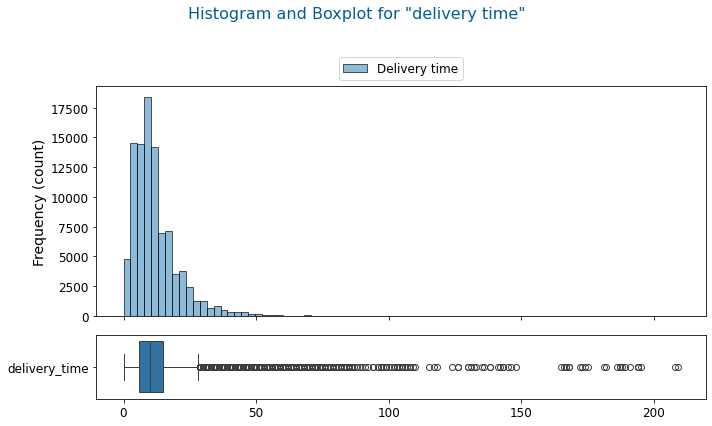

In [798]:
hist_boxplot(['delivery_time'], df['orders'], ['Delivery time'], 80, 'delivery time')

In [799]:
# we see there are outliers, let's look at their borders 
borders_of_outliers('delivery_time', df['orders'])

,Left,Right
Outlier Boundaries,-7.5,28.5
Outlier Count,0.0,5025.0


In [800]:
# del outliers
filter_outliers = df['orders'].delivery_time > 28.5
index_drop = df['orders'][filter_outliers].index
df['orders'] = df['orders'].drop(index_drop).copy()
df['orders'].shape

(94416, 9)

In [801]:
df['orders'].delivery_time.isna().sum()

2965

In [802]:
# del na
filter_outliers = df['orders'].delivery_time.isna()
index_drop = df['orders'][filter_outliers].index
df['orders'] = df['orders'].drop(index_drop).copy()
df['orders'].shape

(91451, 9)

### 2. order_status

<class 'pandas.core.frame.DataFrame'>


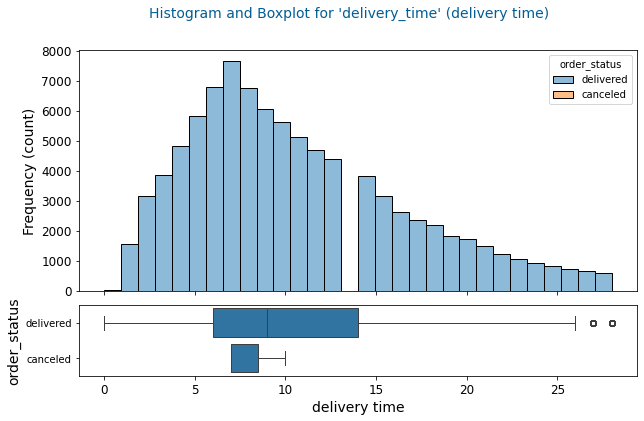

In [803]:
# built histogram and boxplot
hist_boxplot_hue('delivery_time', df['orders'], 'delivery time', 30, 'order_status')

In [804]:
# del 
filter_outliers = df['orders'].order_status != 'delivered'
index_drop = df['orders'][filter_outliers].index
df['orders'] = df['orders'].drop(index_drop).copy()
df['orders'].shape

(91448, 9)

### 3. order_item_id

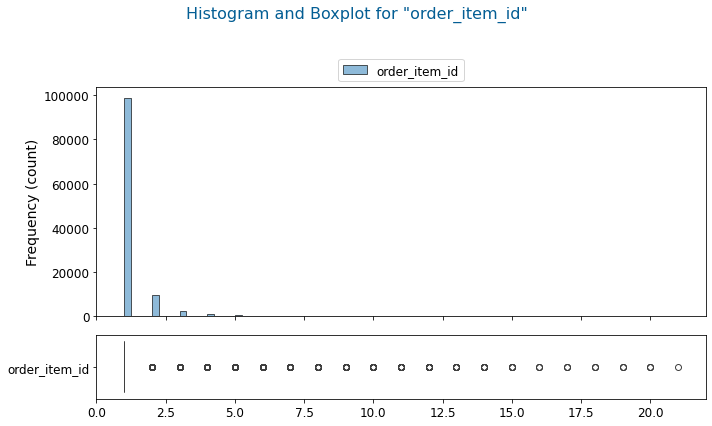

In [805]:
hist_boxplot(['order_item_id'], df['order_items'], ['order_item_id'], 80, 'order_item_id')

In [806]:
# del 
filter_outliers = df['order_items'].order_item_id > 1
index_drop = df['order_items'][filter_outliers].index
df['order_items'] = df['order_items'].drop(index_drop).copy()
df['order_items'].shape

(98666, 7)

In [807]:
delivery_df = df['orders'][['order_id', 
                            'customer_id',
                            'order_purchase_timestamp', 
                            'delivery_time']].merge(
                     df['order_items'][['order_id', 'seller_id', 'price']], 
                     on='order_id',
                     how='inner')
delivery_df.shape

(91448, 6)

### 4. price

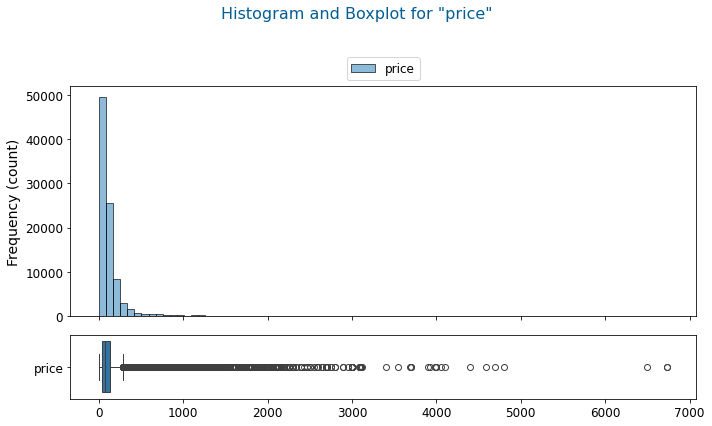

In [808]:
hist_boxplot(['price'], delivery_df, ['price'], 80, 'price')

In [809]:
# sns.pairplot(delivery_df[['delivery_time', 'price']], diag_kind='kde', kind='reg',  height=10, aspect=1.5)

## Preprocessing Merging Datasets

In [810]:
delivery_df = delivery_df.merge(
            df['sellers'][['seller_id', 'seller_zip_code_prefix']], 
            on='seller_id').merge(
                df['customers'][['customer_id', 'customer_zip_code_prefix']], 
                on='customer_id',
                how='inner')
delivery_df.shape

(91448, 8)

In [811]:
delivery_df = delivery_df.merge(
    df['geolocation'][['geolocation_zip_code_prefix', 
                       'geolocation_lat', 
                       'geolocation_lng']].drop_duplicates('geolocation_zip_code_prefix').rename(
                           columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'}),
    on='customer_zip_code_prefix',
    how='inner')
delivery_df.shape                      

(91206, 10)

In [814]:
delivery_df.rename(columns={'geolocation_lat': 'customer_lat',
                            'geolocation_lng': 'customer_lng'}, inplace=True)

In [815]:
delivery_df.head()

,order_id,customer_id,order_purchase_timestamp,delivery_time,seller_id,price,seller_zip_code_prefix,customer_zip_code_prefix,customer_lat,customer_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,8.0,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,9350,3149,-23.574809,-46.587471
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,13.0,289cdb325fb7e7f891c38608bf9e0962,118.70,31570,47813,-12.169860,-44.988369
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,9.0,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,14840,75265,-16.746337,-48.514624
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,13.0,66922902710d126a0e7d26b0e3805106,45.00,31842,59296,-5.767733,-35.275467
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2.0,2c9e548be18521d1c43cde1c582c6de8,19.90,8752,9195,-23.675037,-46.524784


In [816]:
delivery_df.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time',
       'seller_id', 'price', 'seller_zip_code_prefix',
       'customer_zip_code_prefix', 'customer_lat', 'customer_lng'],
      dtype='object')

In [817]:
delivery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91206 entries, 0 to 91205
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  91206 non-null  object        
 1   customer_id               91206 non-null  object        
 2   order_purchase_timestamp  91206 non-null  datetime64[ns]
 3   delivery_time             91206 non-null  float64       
 4   seller_id                 91206 non-null  object        
 5   price                     91206 non-null  float64       
 6   seller_zip_code_prefix    91206 non-null  int64         
 7   customer_zip_code_prefix  91206 non-null  int64         
 8   customer_lat              91206 non-null  float64       
 9   customer_lng              91206 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 7.0+ MB


In [820]:
delivery_df['purchase_weekday_name'] = delivery_df['order_purchase_timestamp'].dt.day_name()

In [821]:
delivery_df['purchase_weekday_name']

0           Monday
1          Tuesday
2        Wednesday
3         Saturday
4          Tuesday
           ...    
91201     Thursday
91202      Tuesday
91203       Sunday
91204       Monday
91205     Thursday
Name: purchase_weekday_name, Length: 91206, dtype: object

In [823]:
from sklearn.metrics import root_mean_squared_error
from catboost import CatBoostRegressor

# Specify categorical and numerical features
categorical = ['seller_zip_code_prefix', 'customer_zip_code_prefix', 'purchase_weekday_name']
numerical = ['customer_lat', 'customer_lng', 'price']
target = 'delivery_time'

# Prepare the training data
X_train = delivery_df[categorical + numerical]
y_train = delivery_df[target]

# Initialize CatBoostRegressor
cat_features = [X_train.columns.get_loc(col) for col in categorical]
model = CatBoostRegressor(cat_features=cat_features, verbose=0)

# Fit the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_train)

# Calculate RMSE
rmse = root_mean_squared_error(y_train, y_pred)
print("RMSE:", rmse)

RMSE: 4.436539548342804


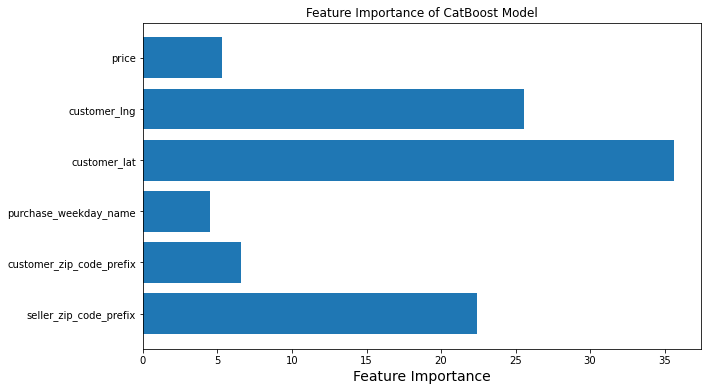

: 

In [ ]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance of CatBoost Model')
plt.show()